In [633]:
import re
import base64
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil import parser

In [832]:
def parse_bdays(x):
    # Year could be first or last; only consider years between 1970? and 2019
    birthday = re.compile(r"([0-1]?[\d])/?([0-3]?[\d])/?((?:[1-2][09]\d\d))")
    birthday2 = re.compile(r"((?:[1-2][09]\d\d))/?([0-1]?[\d])/?([0-3]?[\d])")
    birth = birthday.findall(x)
    birth2 = birthday2.findall(x)
    if birth:
        a,b,c = birth[0]
        if len(a) == 1:
            a = "0" + a
        if len(b) == 1:
            b = "0" + b
        if len(c) == 2:
            c = "20" + c
        if int(a) > 12:
            return c + b + a
        return c + a + b

    elif birth2:
        a,b,c = birth2[0]
        if len(a) == 1:
            a = "0" + a
        if len(b) == 1:
            b = "0" + b
        if len(c) == 1:
            c = "0" + c
        if int(b) > 12:
            return a + c + b
        return a + b + c
    else:
        return 0

In [816]:
def parse_string(x):
    if x != 0:
        string = base64.b64decode(x).decode("utf-8").replace("-", "")
        if string == "m" or string == "MALE" or string == "Male" or string == "male":
            return "M"
        elif string == "f" or string == "FEMALE" or string == "Female" or string == "female":
            return "F"
        else:
            return string
    else:
        return ""

def parse_gender(x):
    if x != "M" and x != "F":
        return 0
    else:
        return x

In [603]:
# df.created_at = df.created_at.apply(parser.parse) # takes a LONG time (write own if datetime is useful)

## Parse DOB M/F etc.

In [840]:
df = pd.read_csv("datapoint_pre_20190113_000000000000.csv", compression='gzip')

In [841]:
# Clean
# Val_boolean is never NaN when property_name is "PREMATURE"
df = df.drop_duplicates()
df.val_boolean = df.val_boolean.fillna(0)
df.val_string = df.val_string.fillna("")

# parse val_string values
df.val_string = df.val_string.apply(parse_string)
# Get rid of non M/F values
mask1 = (df.property_name == "GENDER")
gender = df[mask1]
df.loc[mask1, 'val_string'] = gender.val_string.apply(parse_gender)
# df[df.property_name=="GENDER"] = df[(df.property_name == "GENDER") & (df.val_string.isin(["M", "F"]))]

# parse bdays
mask = (df.property_name == "BIRTHDATE")
bdays = df[mask]
df.loc[mask, 'val_string'] = bdays.val_string.apply(parse_bdays)
df = df[df.val_string != 0]

In [845]:
# df.to_csv("parsed_datapoint_pre_20190113.csv", compression="gzip")

In [842]:
df[df.dsn == "AC000W001123149"]

,dsn,created_at,property_name,base_type,val_boolean,val_string
17499,AC000W001123149,2017-04-19 03:10:46,BIRTHDATE,string,0.0,20170414
55389,AC000W001123149,2017-07-28 08:37:35,BIRTHDATE,string,0.0,20170414
327660,AC000W001123149,2017-07-28 02:20:56,PREMATURE,boolean,0.0,
559954,AC000W001123149,2017-07-28 02:20:55,GENDER,string,0.0,M
639253,AC000W001123149,2017-07-28 02:20:55,BIRTHDATE,string,0.0,19991231


In [ ]:
df_reg[df_reg.dsn == "AC000W001151849"]

In [843]:
df[df.dsn == "AC000W000101826"].sort_values(by="created_at")

,dsn,created_at,property_name,base_type,val_boolean,val_string
28753,AC000W000101826,2017-02-24 05:27:25,BIRTHDATE,string,0.0,20150422
446682,AC000W000101826,2017-02-24 05:27:25,GENDER,string,0.0,F
349650,AC000W000101826,2017-02-25 21:38:22,PREMATURE,boolean,1.0,
54879,AC000W000101826,2017-02-25 21:38:58,BIRTHDATE,string,0.0,20160114
18072,AC000W000101826,2017-03-03 05:01:42,BIRTHDATE,string,0.0,20170302
631755,AC000W000101826,2017-03-03 21:12:56,GENDER,string,0.0,M
259331,AC000W000101826,2017-03-03 21:13:10,BIRTHDATE,string,0.0,20131129
27258,AC000W000101826,2017-03-17 05:50:33,BIRTHDATE,string,0.0,20170316
92301,AC000W000101826,2017-03-17 06:00:31,BIRTHDATE,string,0.0,20170317
328846,AC000W000101826,2017-03-17 20:42:47,PREMATURE,boolean,0.0,


In [ ]:
df[df.dsn == "AC000W000101826"].sort_values(by="created_at")

In [844]:
df.dsn.value_counts()

AC000W000101826    350
AC000W000421783    323
AC000W000459365    257
AC000W000103796    163
AC000W000221576    150
AC000W000338379    147
AC000W000423872    144
AC000W000504805    129
AC000W000459666    109
AC000W000504874    106
AC000W000240434     71
AC000W002444313     66
AC000W000105359     53
AC000W002447092     48
AC000W000237669     46
AC000W000459559     41
AC000W001117455     40
AC000W001046245     38
AC000W000103509     38
AC000W002425973     37
AC000W000334764     33
AC000W002624776     32
AC000W001105306     29
AC000W001089814     29
AC000W000505040     29
AC000W001153564     27
AC000W000364643     27
AC000W002425866     26
AC000W000414716     26
AC000W002449255     23
                  ... 
AC000W000447464      1
AC000W000326017      1
AC000W002432297      1
AC000W001088810      1
AC000W000443058      1
AC000W002606758      1
AC000W000461636      1
AC000W003377988      1
AC000W001106949      1
AC000W002576633      1
AC000W001202098      1
AC000W000669982      1
AC000W00108

### Count invalid Gender values

In [612]:
count = 0
count_null = 0
for v in df[df.property_name == "GENDER"].val_string.values:
    if v == 0:
        count_null += 1
    elif v != "M" and v !="F":
        count += 1

print("Total # of values \t ",len(df[df.property_name == "GENDER"].val_string.values))        
print("# of invalid but not null",count)
print("# of null \t\t ",count_null)
print("percent of invalid values", 100*(count+count_null)/(count + count_null + len(df[df.property_name == "GENDER"].val_string.values)))

Total # of values 	  246000
# of invalid but not null 0
# of null 		  0
percent of invalid values 0.0


In [404]:
# df[(df.val_string != "") & (df.property_name == "GENDER")].val_string.value_counts() # After changing invalid strings to ""

In [822]:
df.val_string[df.property_name == "GENDER"].value_counts()

F    130200
M    115800
Name: val_string, dtype: int64

### Count invalid birthdate values

In [763]:
# Weird bday 
alpha = 0
count_na = 0
count_not_baby = 0
for b in df[df.property_name == "BIRTHDATE"].val_string.values:
    if b == 0:
        count_na += 1
    elif b[0] == "A" or b == "Invalid!":
        alpha += 1
    else:
        try:
            parser.parse(b)
        except:
            print(b)
#     elif b[:3] != "201":
#         try:
#             year = parser.parse(b).year
#             if  year > 2019 or year < 2017:
#                 count_not_baby += 1
# #                 print(parser.parse(b).date())
#         except:
#             if int(b[-4:]) < 1980 or int(b[-4:]) > 2019:
#                 count_not_baby += 1
#                 print(b)
#             else:
#                 try:
#                     num = b.replace("/","")
#                     if len(num) < 8:
#                         num = "0" + num
#                     parser.parse(num[:2] + "/" + num[2:4] + "/" + num[4:])
#                 except:
#                     print("couldn't parse: ", b)

In [425]:
print(len(df[df.property_name == "BIRTHDATE"].val_string.values))

342958


In [571]:
count_not_baby/342958*100

9.737052350433581

In [764]:
total = len(df[df.property_name == "BIRTHDATE"].val_string.values)
print("Total # of values \t ",total)        
print("# of alpha values \t ",alpha)
print("# of null \t\t ",count_na)
print("percent of invalid values", 100*(alpha+count_na)/(alpha+count_na + total))

Total # of values 	  282752
# of alpha values 	  0
# of null 		  0
percent of invalid values 0.012376806571730667


### Check bdays from last night

In [479]:
df_bday = pd.read_csv("unique_birthdate.csv")
# df_bday = df_bday[df_bday.birth_date != "0000-00-00"]

In [480]:
def buckets(x):
    year = int(x[:4])
    month = int(x[5:7])
    day = int(x[8:])
    if year == 0:
        return 0
    elif year > 2018:
        if month > 1 or day > 16:
            return 6
        else:
            return 1
    elif year < 1970:
        return 5
    elif year < 2013:
        return 3
    elif year < 2017:
        return 4
    elif year == 2017 and month < 8 and day < 17:
        return 2
    else:
        return 1
        

In [481]:
df_bday["buckets"] = df_bday.birth_date.apply(buckets)

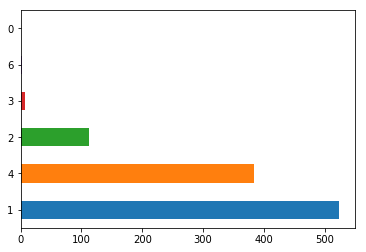

In [498]:
# df_bday.buckets.hist(grid=False, figsize=(15,8), align='mid', rwidth = .5)
df_bday.buckets.value_counts().plot.barh()

In [499]:
df_bday.buckets.value_counts()

1    524
4    384
2    112
3      8
6      3
0      1
Name: buckets, dtype: int64

In [504]:
total = 524+384+112+8+3+1
print("0-18 months\t\t\t", 524/total*100)
print("18-24 months\t\t\t", 112/total*100)
print("2-6 years\t\t\t", 384/total*100)
print("6-50 years\t\t\t", 8/total*100)
print("Birthday before 1970's\t\t", 0/total*100)
print("Birthday after Jan 16 2019\t", 3/total*100)
print("no date\t\t\t\t", 1/total*100)

0-18 months			 50.775193798449614
18-24 months			 10.852713178294573
2-6 years			 37.2093023255814
6-50 years			 0.7751937984496124
Birthday before 1970's		 0.0
Birthday after Jan 16 2019	 0.29069767441860467
no date				 0.09689922480620156


## Parse Registration

In [846]:
# df_reg = pd.read_csv("registration_pre_20190113_000000000000.csv", compression='gzip')

In [847]:
df_reg.head(2)

,dsn,ayla_uuid,registered_at
0,AC000W002625447,08a5cba8-934e-11e6-b0bb-0e03b5e92585,Mon Jul 30 00:34:25 UTC 2018
1,AC000W002633884,0b4054a8-938f-11e8-a7ea-0e9382159dc5,Mon Jul 30 00:34:20 UTC 2018


In [848]:
def date_registered(x):
    if x == 0:
        return " "
    months = {"Jan":"01","Feb":"02","Mar":"03",
          "Apr":"04","May":"05","Jun":"06",
          "Jul":"07","Aug":"08","Sep":"09",
          "Oct":"10","Nov":"11","Dec":"12"}
    return x[-4:] + "-" + months[x[4:7]] + "-" + x[8:10] + " " + x[11:19] # str vs datetime
#     return datetime(int(x[-4:]), int(months[x[4:7]]), int(x[8:10]), int(x[11:13]), int(x[14:16]), int(x[17:19]))

In [849]:
# Clean refistration data
df_reg = df_reg.drop_duplicates().fillna(0)
df_reg.registered_at = df_reg.registered_at.apply(date_registered)

In [853]:
df_reg.to_csv("parsed_registration_pre_20190113.csv", compression="gzip")

In [851]:
df_reg.head(2)

,dsn,ayla_uuid,registered_at
0,AC000W002625447,08a5cba8-934e-11e6-b0bb-0e03b5e92585,2018-07-30 00:34:25
1,AC000W002633884,0b4054a8-938f-11e8-a7ea-0e9382159dc5,2018-07-30 00:34:20


In [575]:
df_reg[df_reg.dsn == "AC000W001123149"].sort_values(by="registered_at")

,dsn,ayla_uuid,registered_at
420851,AC000W001123149,0,
406274,AC000W001123149,fec684b0-24ac-11e7-bac1-0e9382159dc5,2017-04-19 03:10:04
304624,AC000W001123149,70c1668c-2572-11e7-a955-0ab553feed59,2017-04-20 02:41:29
406265,AC000W001123149,fec684b0-24ac-11e7-bac1-0e9382159dc5,2017-04-20 03:31:05
304546,AC000W001123149,70c1668c-2572-11e7-a955-0ab553feed59,2017-04-20 03:32:00
406367,AC000W001123149,fec684b0-24ac-11e7-bac1-0e9382159dc5,2017-04-20 03:35:22
304536,AC000W001123149,70c1668c-2572-11e7-a955-0ab553feed59,2017-04-20 08:31:01
406328,AC000W001123149,fec684b0-24ac-11e7-bac1-0e9382159dc5,2017-04-21 03:04:56
304504,AC000W001123149,70c1668c-2572-11e7-a955-0ab553feed59,2017-04-21 08:24:04
406350,AC000W001123149,fec684b0-24ac-11e7-bac1-0e9382159dc5,2017-04-22 04:05:47
